<a href="https://colab.research.google.com/github/zinab4/T2_AI/blob/main/Untitled58.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import  Adam
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Reshape,Conv2DTranspose, LeakyReLU, Dropout
from tensorflow.keras.utils import load_img, img_to_array, array_to_img, to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

# Add this line to create the 'layers' alias
layers = tf.keras.layers

from IPython import display
print ("tensorflow version: ", tf.__version__ ) # Changed tensorflow to tf here as well
# ... rest of your code

tensorflow version:  2.18.0


In [ ]:
import tensorflow as tf
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import time
import re
from keras.preprocessing.image import img_to_array

In [ ]:
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17838999435048997130
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14619377664
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10819576803964348116
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

load data

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/celeba-dataset


In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle (2).json to kaggle (2).json


In [ ]:
import pandas as pd
import os
import kagglehub # Make sure kagglehub is imported if it's not already

path = kagglehub.dataset_download("jessicali9530/celeba-dataset")

print("Path to dataset files:", path)

attr_file_path = os.path.join(path, 'list_attr_celeba.csv')

data = pd.read_csv(attr_file_path)

# Show the first 5 rows
print(data.head())

Path to dataset files: /kaggle/input/celeba-dataset
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straigh

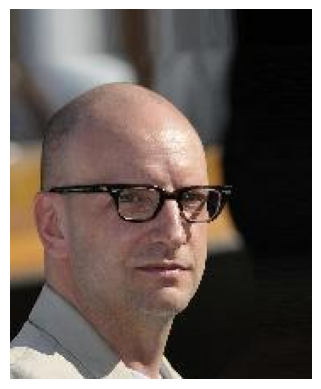

In [ ]:

images_folder = os.path.join(path, 'img_align_celeba', 'img_align_celeba')

image_filename = '196248.jpg'
# Construct the image_path using the correct images_folder
image_path = os.path.join(images_folder, image_filename)

# Add a check to see if the file exists before trying to open it
if not os.path.exists(image_path):
    print(f"Error: Image file not found at {image_path}")
else:
    try:
        img = Image.open(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")


In [ ]:
data.shape

(202599, 41)

In [ ]:

images_folder = os.path.join(path, 'img_align_celeba', 'img_align_celeba') # Assuming this is the correct nested structure


def load_image_as_array(image_id):
    path = os.path.join(images_folder, image_id)
    # Add a check to see if the file exists before trying to open it
    if not os.path.exists(path):
        print(f"Warning: Image file not found at {path}. Skipping.")
        return None

    try:
        img = Image.open(path)
        return np.array(img)
    except Exception as e:
        print(f"Error loading image {path}: {e}. Skipping.")
        return None


# Accessing the first image_id from the data DataFrame
first_image_id = data.loc[0, 'image_id']
img_array = load_image_as_array(first_image_id)

if img_array is not None:
    print(f"Shape of the first image array: {img_array.shape}")
else:
    print(f"Could not load image {first_image_id}")

Shape of the first image array: (218, 178, 3)


In [ ]:
BUFFER_SIZE = 30000

BATCH_SIZE = 32

Attempting to access DATA_DIR: /kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba


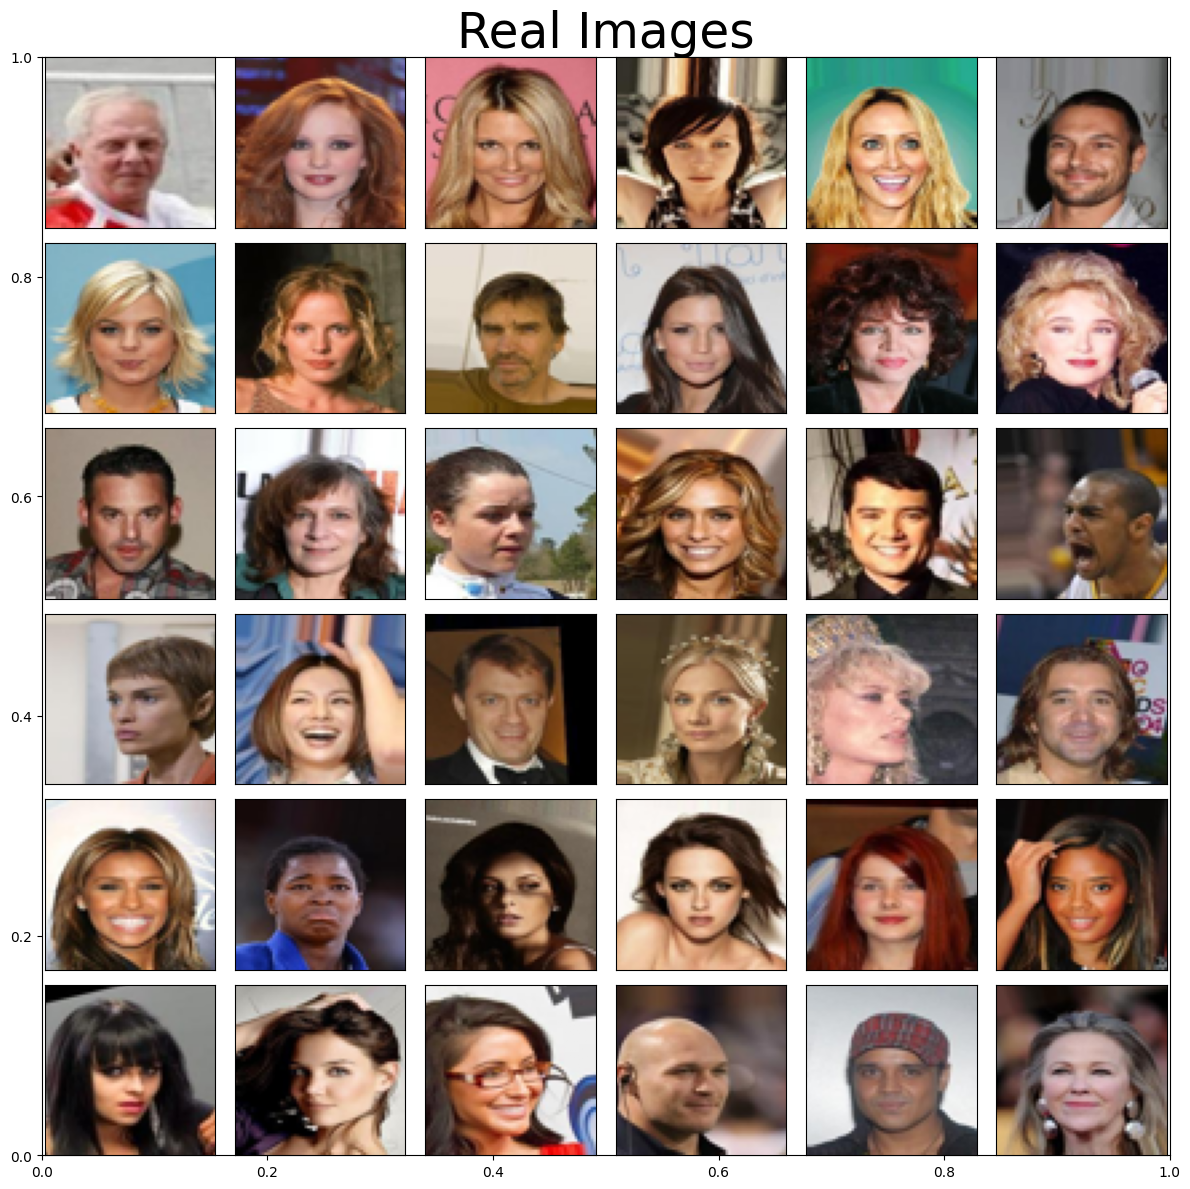

In [ ]:

DATA_DIR = os.path.join(path, 'img_align_celeba', 'img_align_celeba')

print(f"Attempting to access DATA_DIR: {DATA_DIR}")

IMG_SIZE = 64

image_extensions = ['.jpg', '.jpeg', '.png']
all_image_files = os.listdir(DATA_DIR)
all_image_files = [f for f in all_image_files if os.path.splitext(f)[1].lower() in image_extensions]

num_images_to_plot = 6 * 6
# Select a random sample of image filenames
if len(all_image_files) >= num_images_to_plot:
    selected_image_files = random.sample(all_image_files, num_images_to_plot)
else:
    # Handle the case where there are fewer images than you want to plot
    print(f"Warning: Only {len(all_image_files)} images available, attempting to plot fewer.")
    selected_image_files = all_image_files
    num_images_to_plot = len(all_image_files) # Update num_images_to_plot
_img = []
for filename in selected_image_files:
    try:
        img_path = os.path.join(DATA_DIR, filename)
        img = Image.open(img_path)
        # Resize images to the desired GAN size
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img)
      )
        if len(img_array.shape) == 2:
            img_array = np.stack((img_array,)*3, axis=-1)
        elif img_array.shape[-1] == 4: # Remove alpha channel if present
             img_array = img_array[..., :3]
        # Normalize pixel values to be between -1 and 1 as per the plotting function and GAN
        img_array = (img_array.astype(np.float32) / 127.5) - 1.0
        _img.append(img_array)
    except Exception as e:
        print(f"Could not load or process image {filename}: {e}")


_img = np.array(_img)

def plot_images(sqr = 5):
    plt.figure(figsize = (sqr * 2, sqr * 2))
    plt.title("Real Images",fontsize = 35)
    num_to_plot = min(sqr * sqr, len(_img))
    for i in range(num_to_plot):
        plt.subplot(sqr,sqr,i+1)
        plt.imshow(_img[i]*0.5 + 0.5 )
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout() # Improve layout
    plt.show()
plot_images(6)

In [ ]:
batch_size = 32
# Convert the loaded and resized images to a TensorFlow dataset
dataset=tf.data.Dataset.from_tensor_slices(np.array(_img)).batch(batch_size)

In [ ]:
latent_dim = 100
def Generator():
    model = tf.keras.Sequential()
    # Use tf.keras.layers.Dense, adjust size to produce features that result in 4x4 after reshape
    model.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(latent_dim,)))
    # Use tf.keras.layers.Reshape to start with a spatial dimension that can be upsampled
    model.add(tf.keras.layers.Reshape((4,4,512)))

    # Upsampling layers to reach 64x64
    model.add(tf.keras.layers.Conv2DTranspose(256, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)) # 4x4 -> 8x8
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)) # 8x8 -> 16x16
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)) # 16x16 -> 32x32
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(32, 4, strides=2,padding='same',kernel_initializer='he_normal',use_bias=False)) # 32x32 -> 64x64
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # Final layer to output 64x64x3 image
    model.add(tf.keras.layers.Conv2D(3,4,strides = 1, padding = 'same',activation = 'tanh')) # Keep 64x64 size

    return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


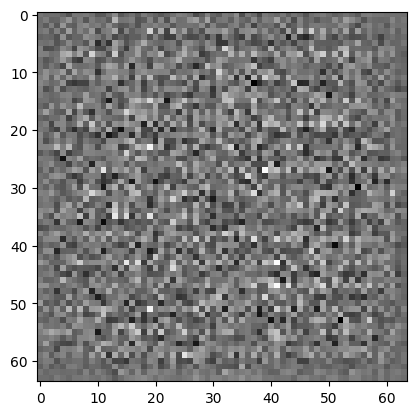

In [ ]:
generator = Generator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
generator = Generator()
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 8192)           │       819,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 8, 8, 256)      │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 16, 16, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 32, 32, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 64, 64, 32)     │        32,768 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 3)      │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,607,939 (13.76 MB)

 Trainable params: 3,606,979 (13.76 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
def Discriminator():
    model = tf.keras.models.Sequential()
    # Define SIZE before using it in the Input layer
    SIZE = 64
    model.add(tf.keras.layers.Input((SIZE, SIZE, 3)))
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)) # 64x64 -> 32x32
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(128,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)) # 32x32 -> 16x16
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)) # 16x16 -> 8x8
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(256,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)) # 8x8 -> 4x4
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Conv2D(512,4, strides=2, padding='same',kernel_initializer='he_normal', use_bias=False)) # 4x4 -> 2x2 - Changed stride to 2
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Flatten()) # (None, 2, 2, 512) -> (None, 2048)
    model.add(tf.keras.layers.Dense(1,activation = 'sigmoid'))
    return model

In [ ]:

discriminator = Discriminator()
discriminator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 128)    │       262,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       524,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 256)      │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 2, 2, 512)      │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,943,425 (15.04 MB)

 Trainable params: 3,941,889 (15.04 MB)

 Non-trainable params: 1,536 (6.00 KB)

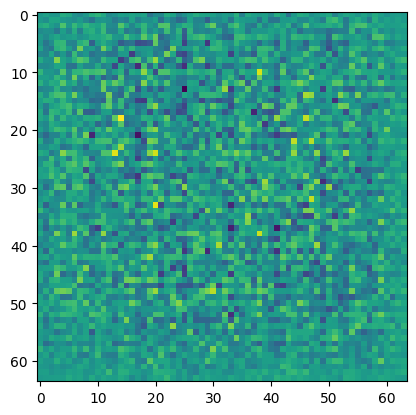

In [ ]:
noise = np.random.normal(-1,1,(1,100))
img = generator(noise)
plt.imshow(img[0,:,:,0])
plt.show()

In [ ]:
optimizer_g = tf.keras.optimizers.RMSprop(
    learning_rate=.0001,
    clipvalue=1.0,
    decay=1e-8
)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
optimizer_d = tf.keras.optimizers.RMSprop(
        learning_rate=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)
def discriminator_loss(fake_output, real_output):
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    return fake_loss + real_loss

In [ ]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def train_steps(images):
    noise = np.random.normal(0,1,(batch_size,latent_dim))
    with tf.GradientTape() as gen_tape , tf.GradientTape() as disc_tape:
        generated_images = generator(noise)
        fake_output = discriminator(generated_images)
        real_output = discriminator(images)

        gen_loss = generator_loss(fake_output)
        dis_loss = discriminator_loss(fake_output, real_output)


    gradient_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradient_of_discriminator = disc_tape.gradient(dis_loss, discriminator.trainable_variables)

    # Use the correct optimizers to apply gradients
    optimizer_g.apply_gradients(zip(gradient_of_generator,generator.trainable_variables))
    optimizer_d.apply_gradients(zip(gradient_of_discriminator, discriminator.trainable_variables))

    loss = {'gen loss':gen_loss,
           'disc loss': dis_loss}
    return loss


In [ ]:
def plot_generated_images(square=5, epochs=0):
    plt.figure(figsize=(10, 10))
    for i in range(square * square):
        if epochs != 0:
            if i == (square * square) // 2:
                plt.title(f"Generated Image at Epoch: {epochs}", fontsize=32, color='black')

        plt.subplot(square, square, i + 1)
        noise = np.random.normal(0, 1, (1, latent_dim))
        img = generator(noise, training=False)
        plt.imshow(np.clip((img[0, ...] + 1) / 2, 0, 1))  # Normalize from [-1, 1] to [0, 1]
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

    plt.tight_layout()
    plt.show()


In [ ]:
import time
def train(epochs,dataset):

    for epoch in range(epochs):
        start = time.time()
        print("\nEpoch : {}".format(epoch + 1))
        for images in dataset:
            loss = train_steps(images)
        print(" Time:{}".format(np.round(time.time() - start),2))
        print("Generator Loss: {} Discriminator Loss: {}".format(loss['gen loss'],loss['disc loss']))

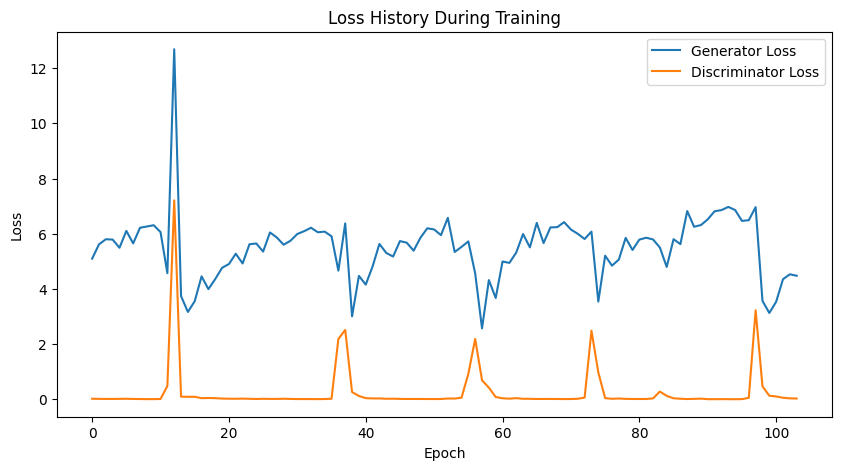

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=optimizer_g,
                                 discriminator_optimizer=optimizer_d,
                                 generator=generator,
                                 discriminator=discriminator)

# Define the generate_and_save_images function
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      # Ensure predictions are scaled correctly for displaying as images
      # Assuming predictions are in [-1, 1], convert to [0, 1]
      plt.imshow((predictions[i, :, :, :] + 1) / 2)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      # Corrected function call from train_step to train_steps
      train_steps(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  show_generated_images(generated_images)
  # Plot loss history after training is complete
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label='Generator Loss')
plt.plot(discriminator_losses, label='Discriminator Loss')
plt.title("Loss History During Training")
plt.xlabel("Epoch") # Changed xlabel to Epoch as we are plotting per epoch loss
plt.ylabel("Loss")
plt.legend()
plt.show()

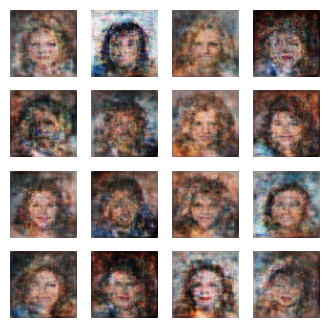

In [ ]:
# Call the train function
train(dataset,500)

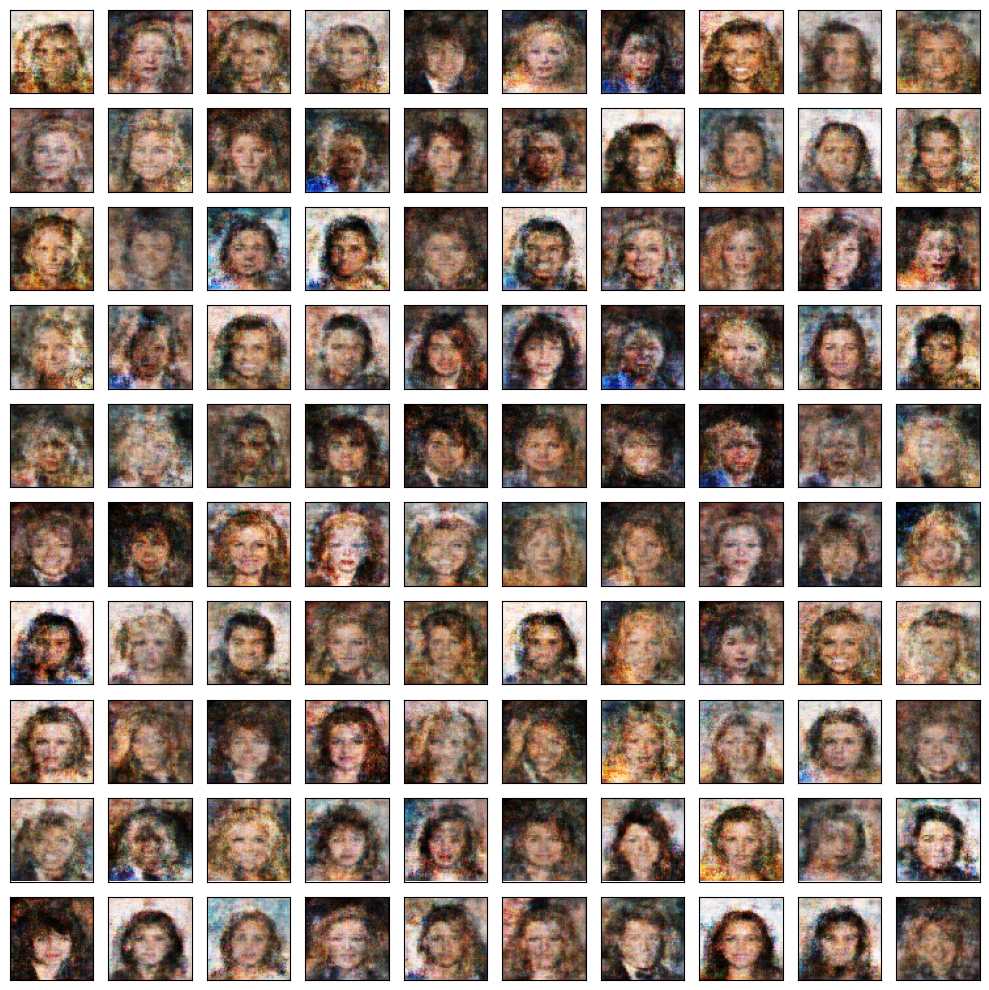

In [ ]:
plot_generated_images(10)

In [ ]:
plot_generated_images(7)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


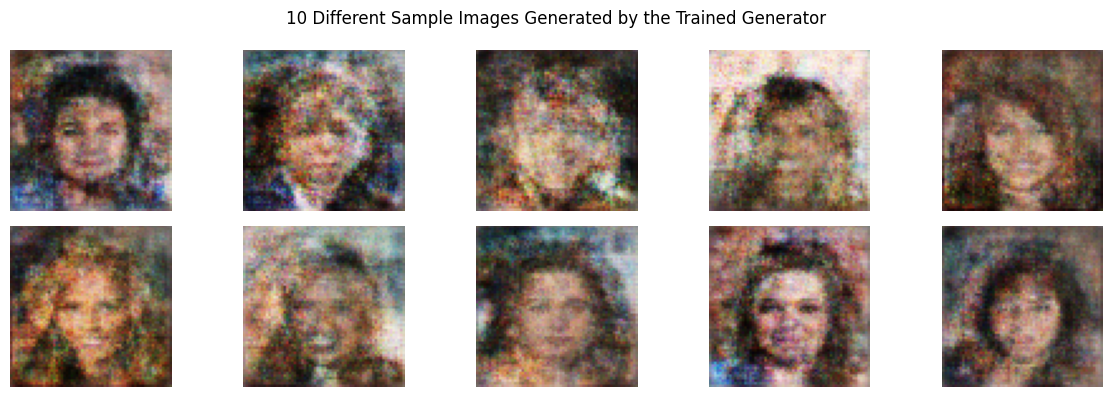

In [ ]:


noise = np.random.normal(0, 1, (10, latent_dim))

generated_images = generator.predict(noise)
generated_images = (generated_images + 1) / 2

plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    img = generated_images[i]
    if img.shape[-1] == 1:
        img = img.squeeze(-1)
        plt.imshow(img)
    else:
        plt.imshow(img)
    plt.axis('off')
plt.suptitle("10 Different Sample Images Generated by the Trained Generator")
plt.tight_layout()
plt.show()
